# 자동차 연비 예측하기: 회귀

*회귀*(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 이와는 달리 *분류*(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다(예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것).

이 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

이 예제는 `tf.keras` API를 사용합니다. 자세한 내용은 [케라스 가이드](https://www.tensorflow.org/guide/keras)를 참고하세요.

In [ ]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
# !pip install -q seaborn
%pip install tqdm ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt        # MATLAB 호환

# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac (AppleGothic 또는 AppleSDGothicNeo)
# plt.rcParams['font.family'] = 'NanumGothic' # Linux (NanumGothic 또는 다른 설치된 한글 폰트)

plt.rcParams['axes.unicode_minus'] = False #glypy 8722: Axes에 - 표시 안되는 것
# plt.title('한글 타이틀...')

In [ ]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #0: 모든 메시지, 1: 정보 숨김, 2: 경고 숨김, 3: 에러만 출력)

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split

## Auto MPG 데이터셋

이 데이터셋은 [UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.
 - https://archive.ics.uci.edu/dataset/9/auto+mpg

먼저 데이터셋을 다운로드합니다.

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

      0/Unknown 0s 0s/step

'/root/.keras/datasets/auto-mpg.data'

판다스를 사용하여 데이터를 읽습니다.

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']




dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


## EDA


엔진 크기에 따른 주행 마일수에 대한 관계, 영향력을 살펴보기 위해서 산점도 그래프를 그려보자.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50644 (\N{HANGUL SYLLABLE EN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

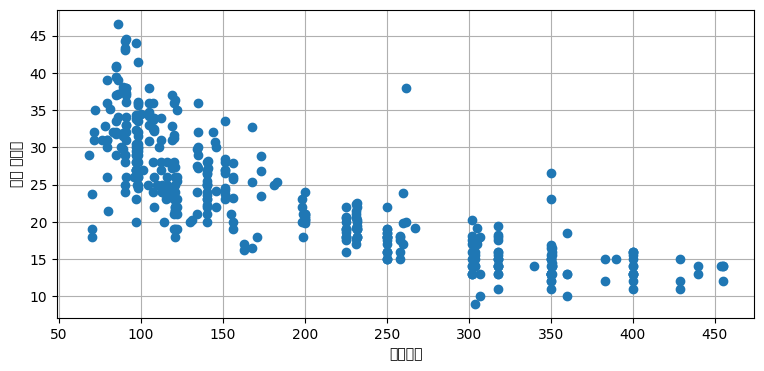

In [ ]:
plt.figure(figsize=(9,4))




plt.xlabel('Engine')
plt.ylabel('Mile')
plt.grid(True)
plt.show()

엔진 크기가 작을 수록 주행 마일수가 긴것을 확인할 수 있다.

### 데이터 클린징

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


결측치를 처리합니다

In [ ]:
median_horsepower = dataset['Horsepower'].median()
dataset['Horsepower'] = dataset['Horsepower'].fillna(median_horsepower)

/tmp/ipython-input-14-1982718748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Horsepower'] = dataset['Horsepower'].fillna(median_horsepower)


In [ ]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,0
Weight,0
Acceleration,0
Model Year,0
Origin,0


### 단변량 분석



In [ ]:
raw_dataset.columns[:-1]

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year'],
      dtype='object')

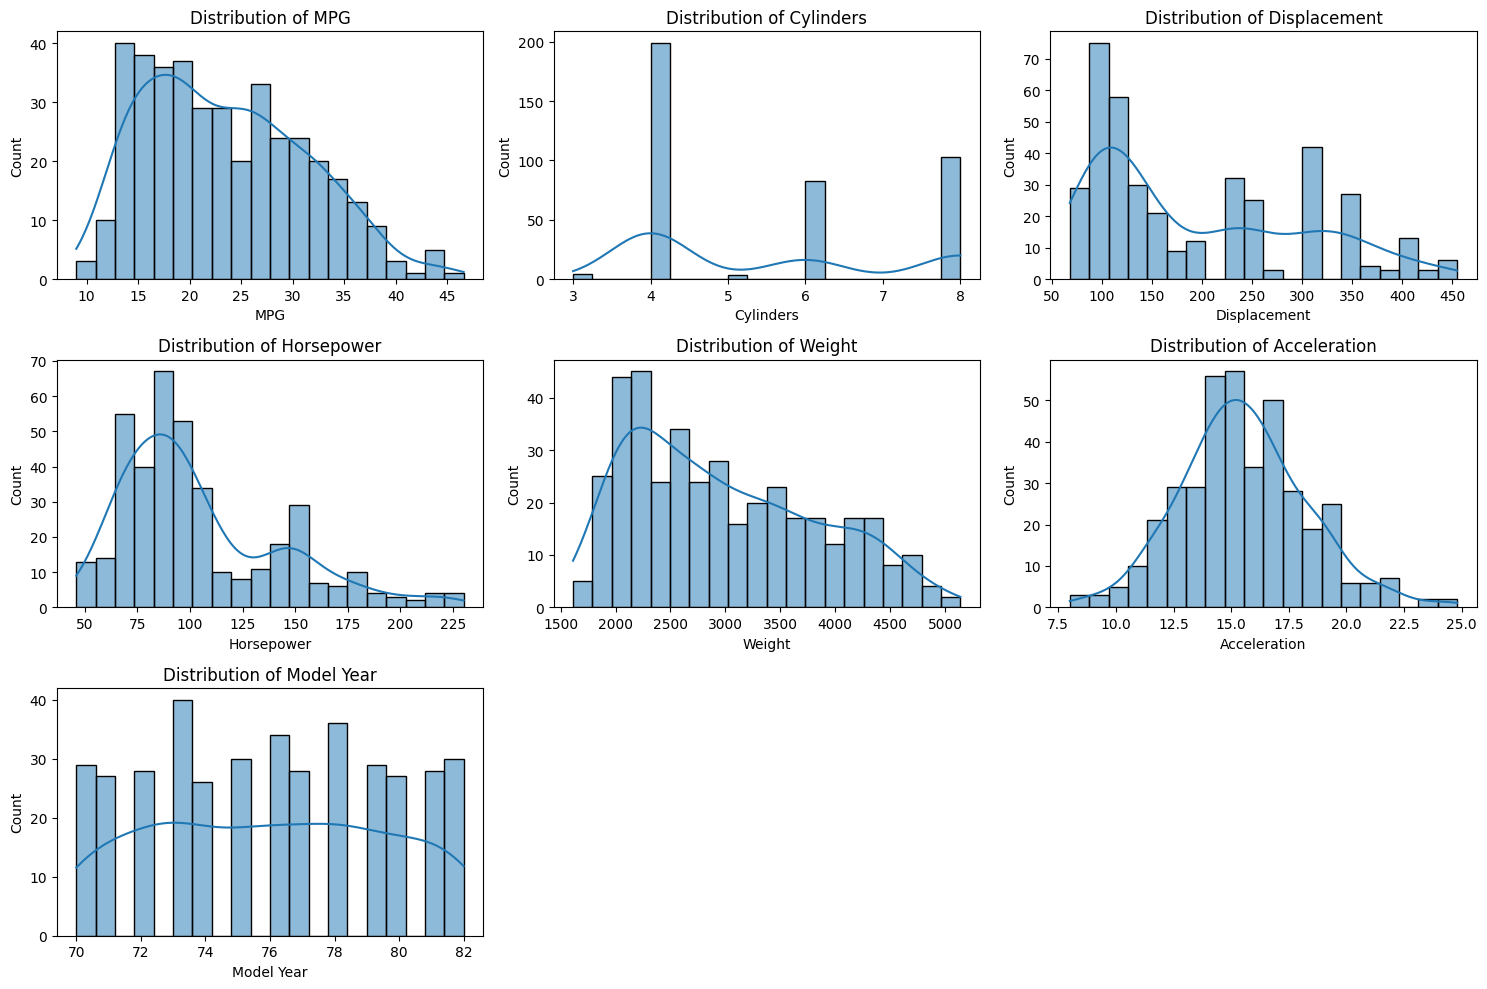

In [ ]:
# Histograms for numerical features
# numerical_features = [
#     "MPG", "cylinders", "displacement", "horsepower",
#      "weight", "acceleration", "model year"
# ]
numerical_features = raw_dataset.columns[:-1]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):


    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

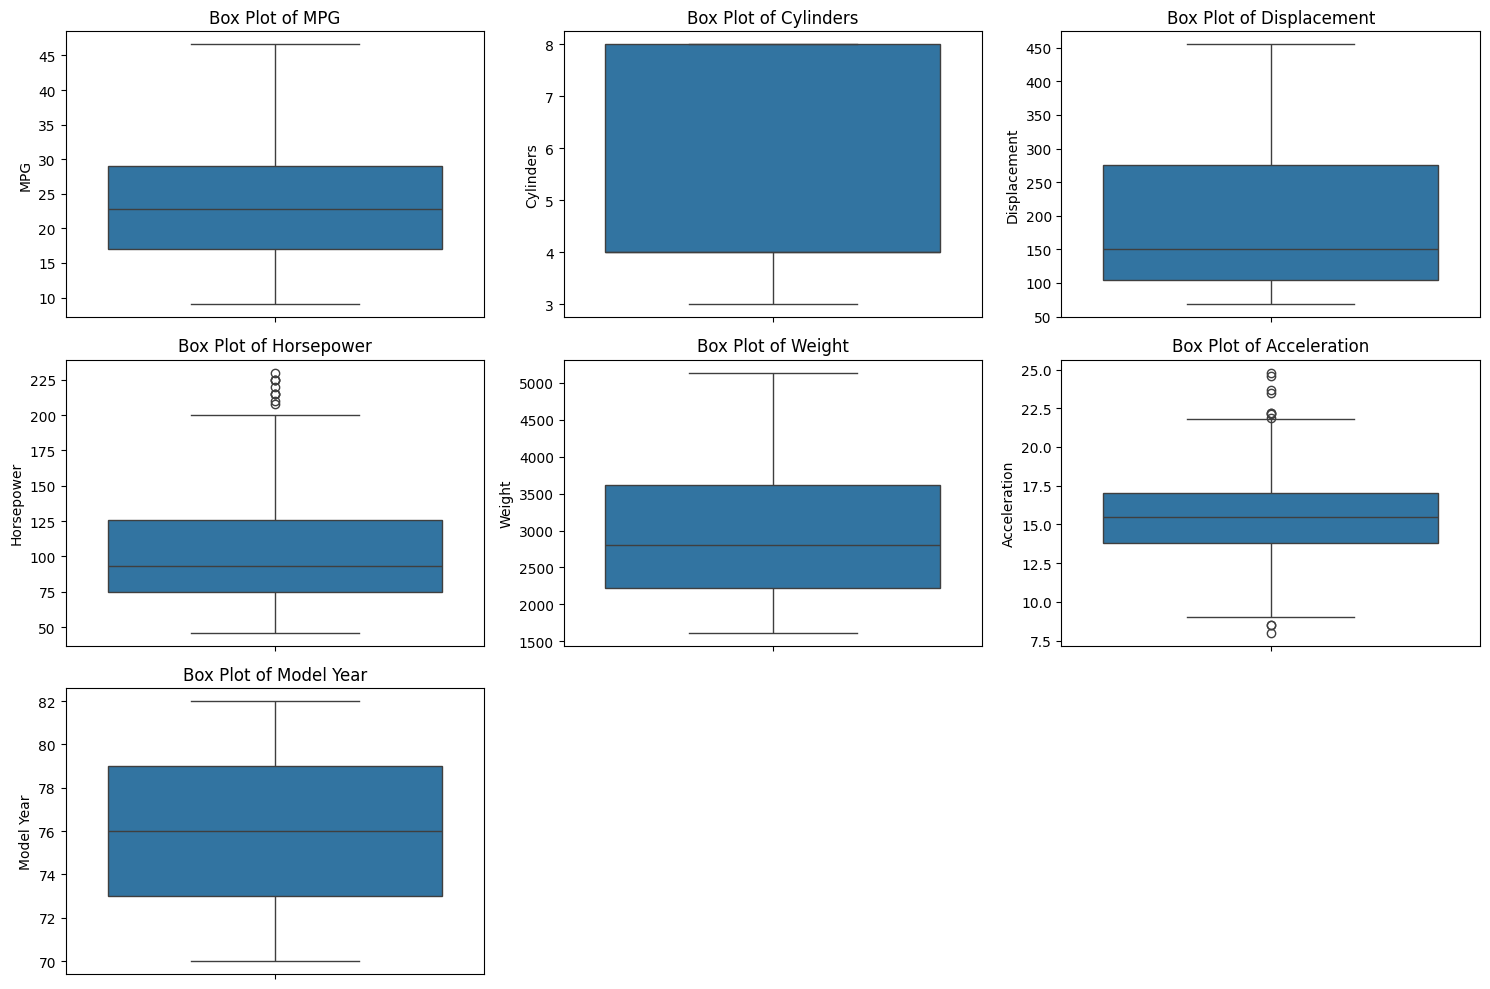

In [ ]:
numerical_features = raw_dataset.columns[:-1]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):


    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

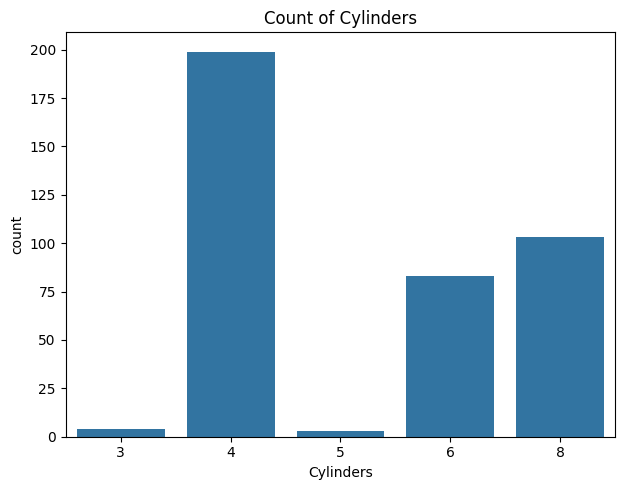

In [ ]:
# Count plot for 'cylinders' and 'origin' (categorical/discrete features)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)


plt.title('Count of Cylinders')

plt.tight_layout()
plt.show()

### 이변량 분석



Step 5: Bivariate Analysis


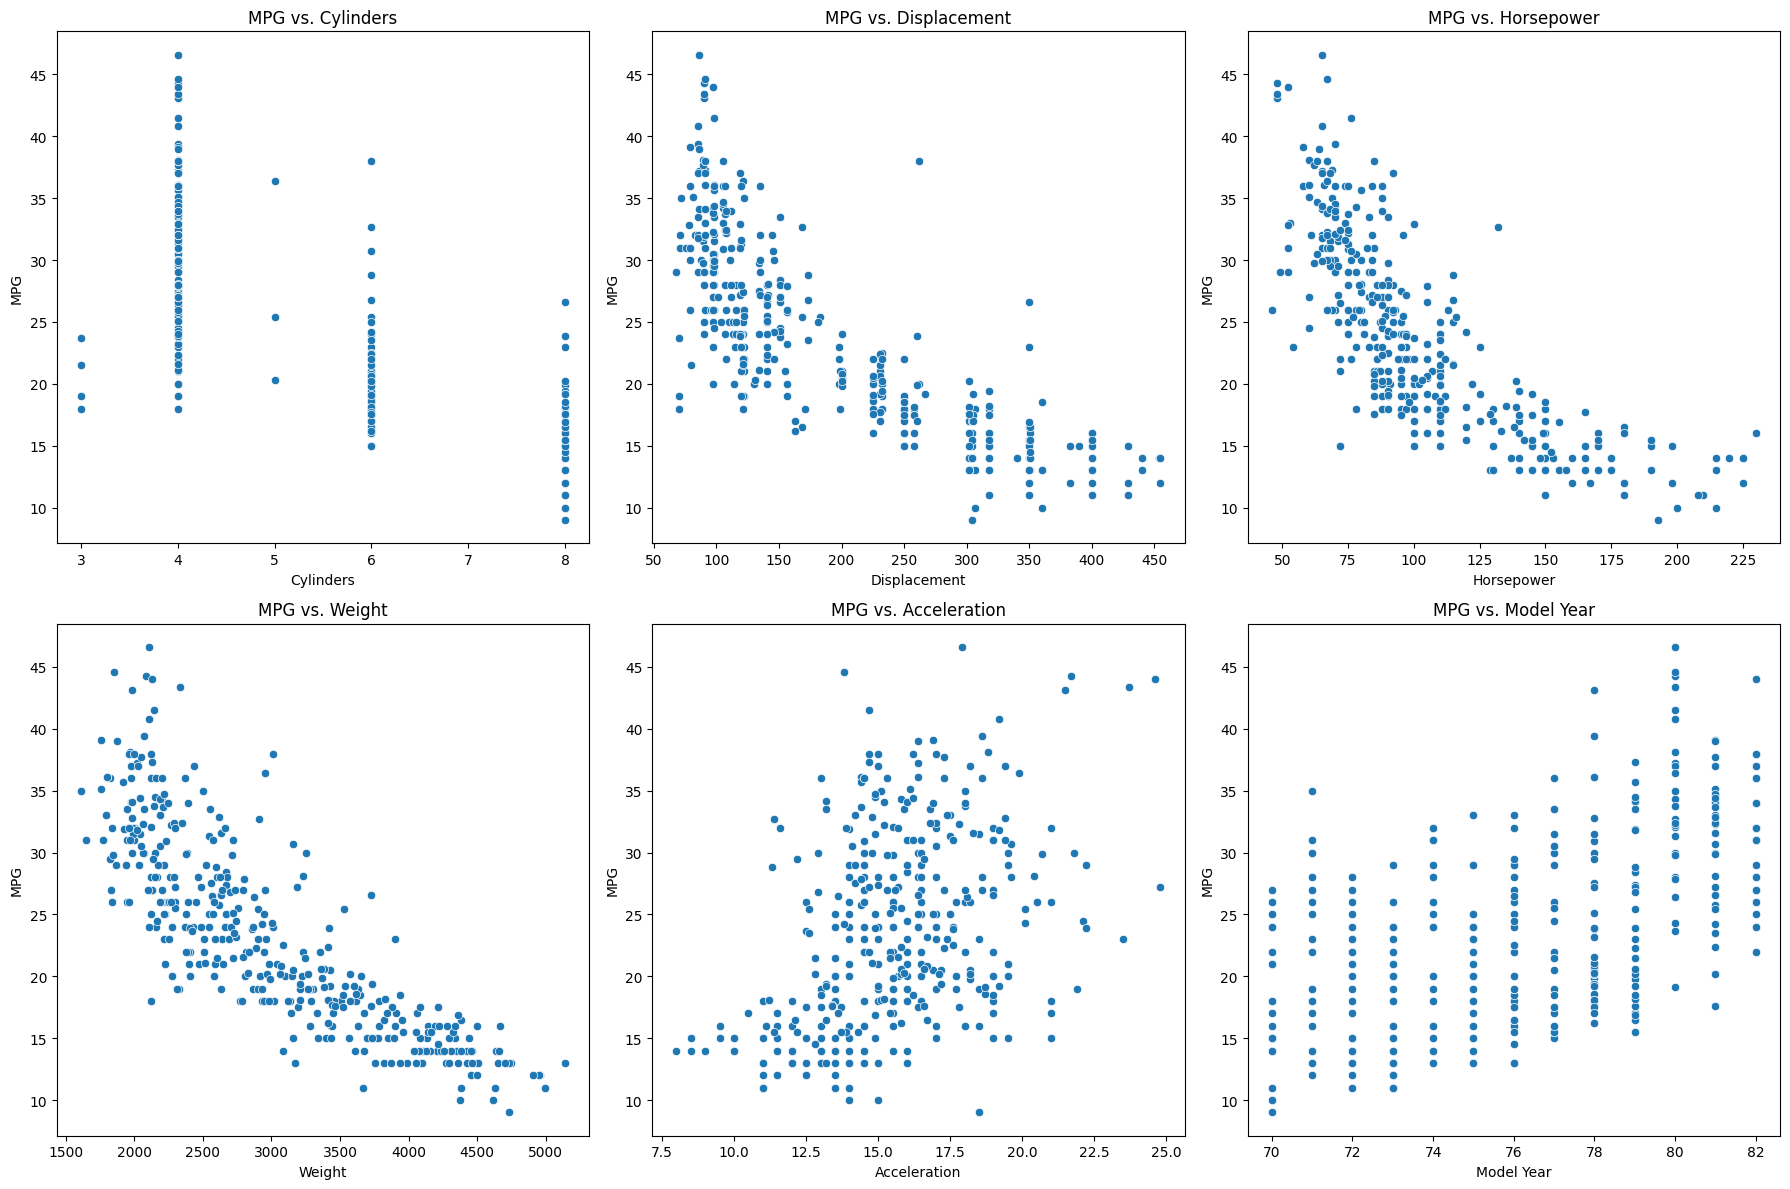

In [ ]:
# MPG 대비 수치형 데이터
cols_for_scatter = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year']
plt.figure(figsize=(18, 12))
for i, feature in enumerate(cols_for_scatter):
    plt.subplot(2, 3, i + 1)


    plt.title(f'MPG vs. {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Pair plot


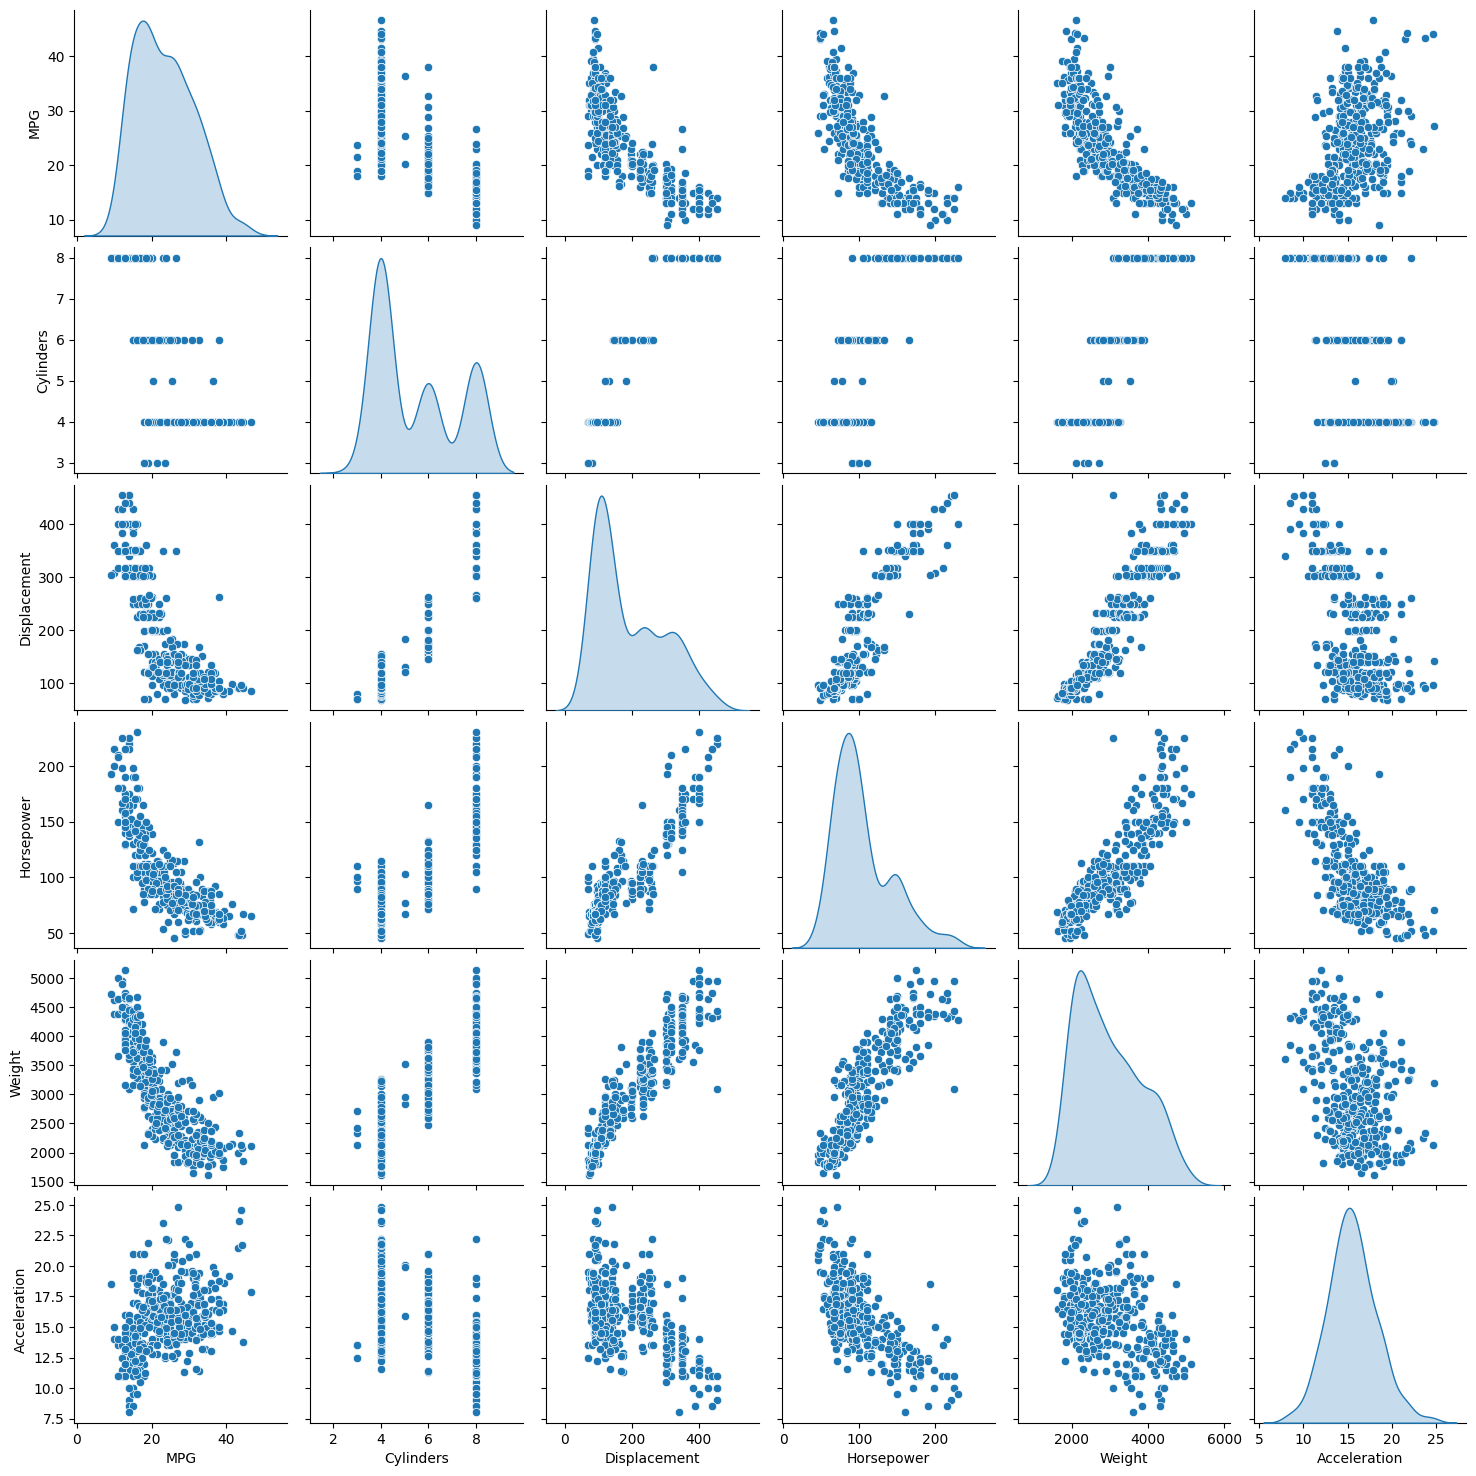

In [ ]:
cols_for_paireplot = ['MPG','Cylinders', 'Displacement', 'Horsepower', 'Weight','Acceleration']

# seaborn pairplot
sns.pairplot(dataset[cols_for_paireplot], diag_kind="kde")

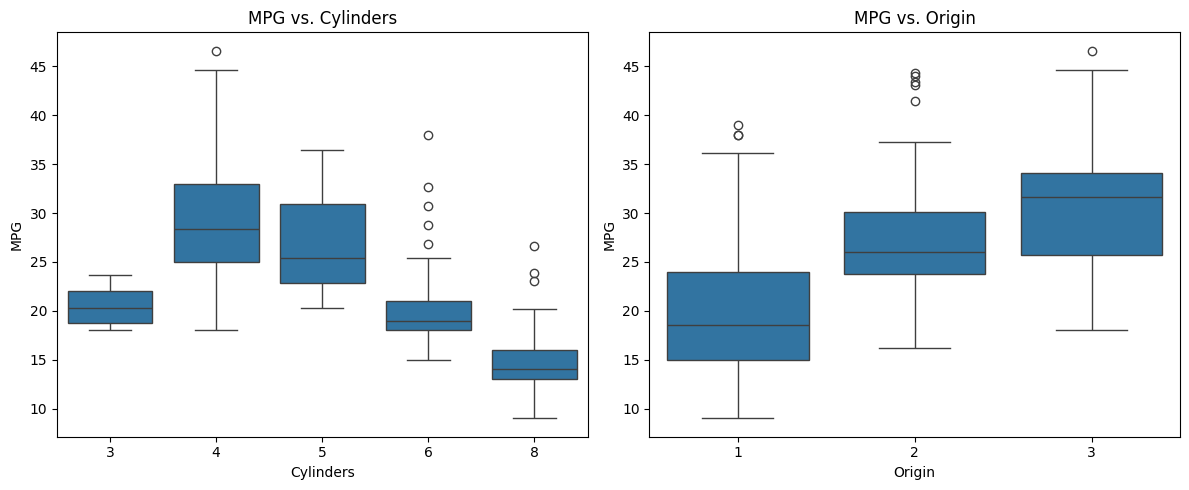

------------------------------


In [ ]:
# Box plot of MPG vs. Cylinders
# Box plot of MPG vs. Origin
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.title('MPG vs. Cylinders')

plt.subplot(1, 2, 2)

plt.title('MPG vs. Origin')
plt.tight_layout()
plt.show()
print("-" * 30)

### 다변량 분석


In [ ]:
dataset.head(3)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


In [ ]:
# 상관계수

print("\nCorrelation Matrix:")

print(correlation_matrix)



Step 6: Multivariate Analysis

Correlation Matrix:
                   MPG  Cylinders  Displacement  Horsepower    Weight  \
MPG           1.000000  -0.777618     -0.805127   -0.778427 -0.832244   
Cylinders    -0.777618   1.000000      0.950823    0.842983  0.897527   
Displacement -0.805127   0.950823      1.000000    0.897257  0.932994   
Horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
Weight       -0.832244   0.897527      0.932994    0.864538  1.000000   
Acceleration  0.423329  -0.504683     -0.543800   -0.689196 -0.416839   
Model Year    0.580541  -0.345647     -0.369855   -0.416361 -0.309120   
Origin        0.565209  -0.568932     -0.614535   -0.455171 -0.585005   

              Acceleration  Model Year    Origin  
MPG               0.423329    0.580541  0.565209  
Cylinders        -0.504683   -0.345647 -0.568932  
Displacement     -0.543800   -0.369855 -0.614535  
Horsepower       -0.689196   -0.416361 -0.455171  
Weight           -0.416839   -0.309

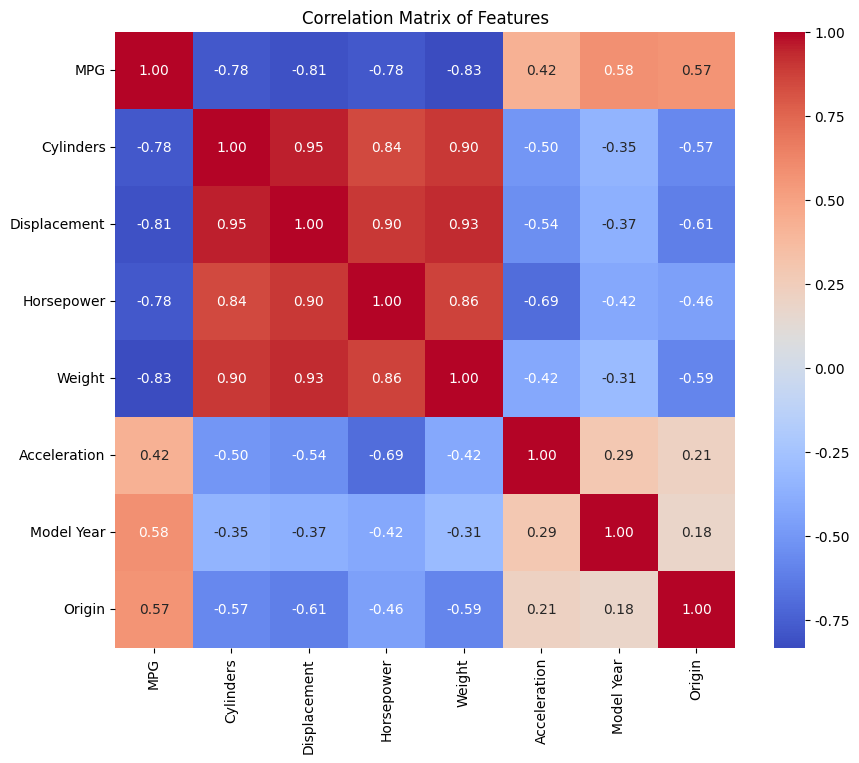

In [ ]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))


plt.title('Correlation Matrix of Features')
plt.show()

## 데이터셋을 훈련 세트와 테스트 세트로 분할하기



이제 데이터를 훈련 세트와 테스트 세트로 분할합니다. 테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [ ]:
train_dataset =
test_dataset =

In [ ]:
train_dataset.shape, test_dataset.shape

((314, 8), (78, 8))

### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

In [ ]:
train_labels =
test_labels =

### 데이터 정규화

위 `train_stats` 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보죠.

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

노트: 의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.

전반적인 통계도 확인해 보죠:

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [ ]:
train_dataset.columns

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Origin'],
      dtype='object')

In [ ]:
def norm(x):



normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련합니다.

주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

,0
Cylinders,0
Displacement,0
Horsepower,0
Weight,0
Acceleration,0
Model Year,0
Origin,0


np.int64(0)

## 모델

### 모델 만들기

모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 `Sequential` 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다.

In [ ]:
len(train_dataset.keys())

7

In [ ]:
model =









모델은 1갤런당 주행 MPG를 학습하게 된다. 결과적으로 모델의 손실함수 mse 차이 만큼의 오차를 가진 예측을 수행하게 될 것이다.

### 모델 확인

`.summary` 메서드를 사용해 모델에 대한 간단한 정보를 출력합니다.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

모델을 한번 실행해 보죠. 훈련 세트에서 `10` 샘플을 하나의 배치로 만들어 `model.predict` 메서드를 호출해 보겠습니다.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


array([[ 0.07254899],
       [-0.04713693],
       [ 0.01468852],
       [ 0.03212976],
       [-0.05233377],
       [ 0.00547701],
       [-0.01176985],
       [-0.01722395],
       [ 0.00753994],
       [-0.05199997]], dtype=float32)

In [ ]:
train_labels[:10]

제대로 작동하는 것 같네요.

### 모델 훈련

1. `fit(callbacks=[]...)` 를 활용해 출력 내용을 조절한다
1. 모델을 1,000번의 에포크(epoch) 동안 훈련합니다. 훈련 정확도와 검증 정확도는 `history` 객체에 기록됩니다.

In [ ]:
from tqdm.keras import TqdmCallback

EPOCHS = 1000







0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해 보죠.

In [ ]:




hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,6.157966,1.727954,6.157966,9.493834,2.327393,9.493834,995
996,6.146716,1.724791,6.146716,9.492453,2.323949,9.492453,996
997,6.150230,1.725293,6.150230,9.495656,2.320419,9.495656,997
998,6.163063,1.727198,6.163063,9.491680,2.320910,9.491680,998
999,6.145607,1.725237,6.145607,9.492466,2.318505,9.492466,999


Epoch 동안 MSE 와 MSE^2

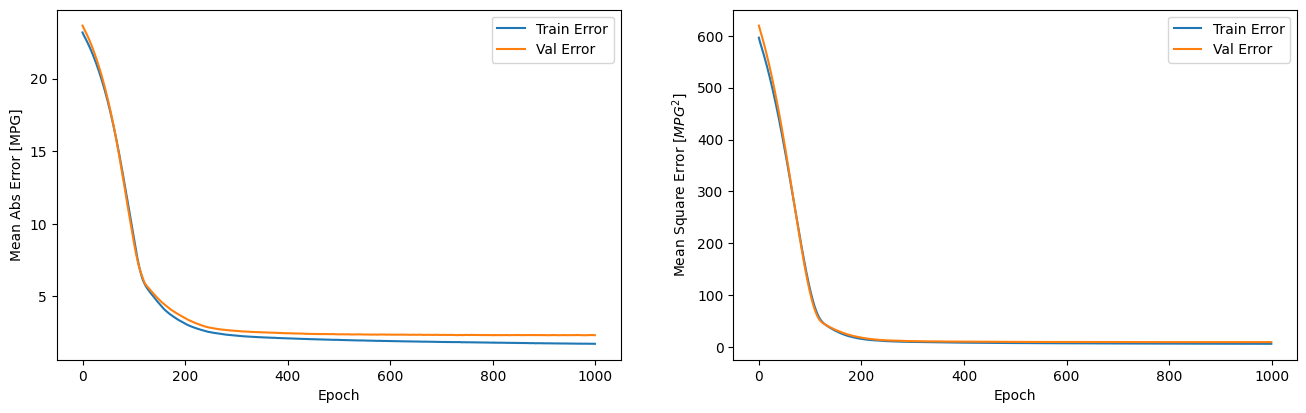

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,10))

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    # plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. `model.fit` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠. 에포크마다 훈련 상태를 점검하기 위해 *EarlyStopping 콜백(callback)*을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

## Earlystopping

In [ ]:
model =







/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

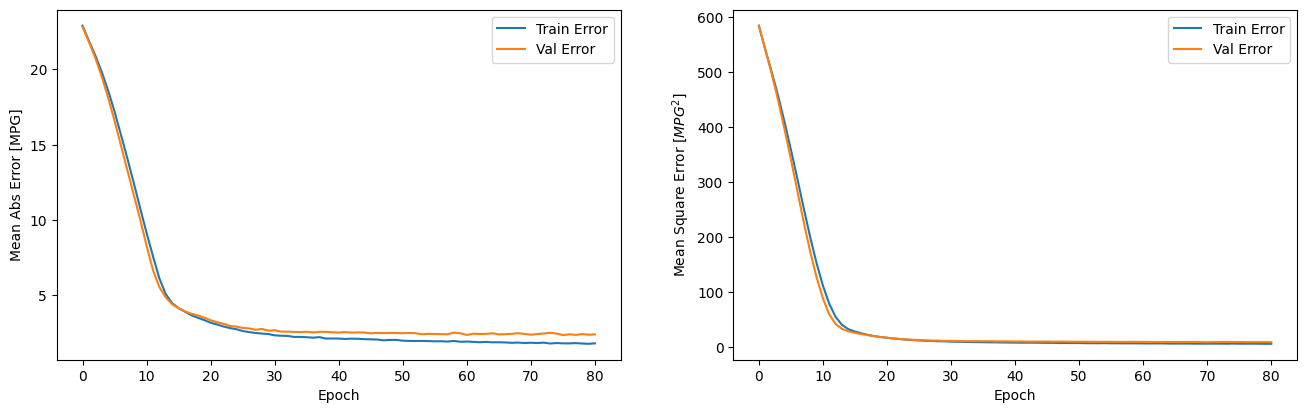

In [ ]:
from tqdm.keras import TqdmCallback

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다







plot_history(history)

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG입니다. 좋은 결과인가요? 이에 대한 평가는 여러분에게 맡기겠습니다.

모델을 훈련할 때 사용하지 않았던 **테스트 세트**에서 모델의 성능을 확인해 보죠. 이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다:

In [ ]:


print("테스트 세트 MAE: {:5.2f} MPG".format(mae))
print("테스트 세트 MSE: {:5.2f} MPG".format(mse))

3/3 - 0s - 15ms/step - loss: 6.7836 - mae: 1.9520 - mse: 6.7836
테스트 세트 MAE:  1.95 MPG
테스트 세트 MSE:  6.78 MPG


## 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


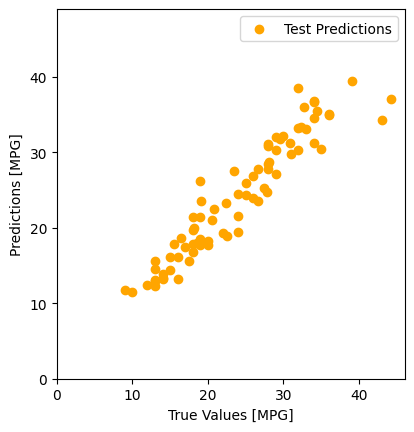

In [ ]:


# Plotting test predictions (True MPG vs Predicted MPG)


plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
plt.show()

모델이 꽤 잘 예측한 것 같습니다. 오차의 분포를 살펴 보죠.

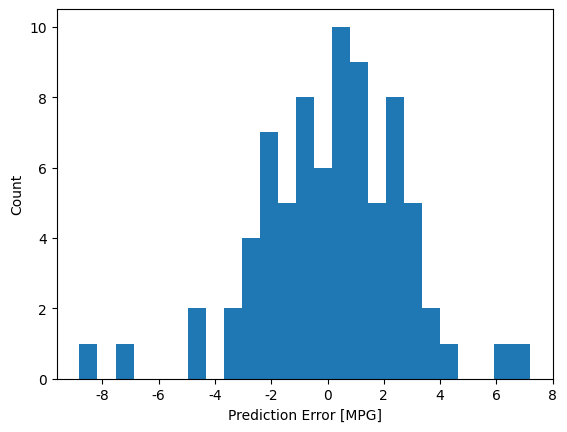

In [ ]:



plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()

가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문일 것입니다.

## 정리

회귀 학습시

* 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다
* 회귀에서 사용되는 평가 지표는 평균 절댓값 오차(MAE)입니다.
* 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
* 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.